In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/lucasweyrich958/Banking_Churn/refs/heads/main/churn_prediction.csv'
raw = pd.read_csv(url, index_col=0)


### Exploratory Data Analysis

In [2]:
missing_data = raw.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64


In [3]:
# Drop 'city' and 'dependents' columns
raw = raw.drop(columns=['city', 'dependents'])

# Impute missing values with the mode for 'gender'
raw['gender'].fillna(raw['gender'].mode()[0], inplace=True)

# Impute missing values with the mode for 'occupation'
raw['occupation'].fillna(raw['occupation'].mode()[0], inplace=True)

# Confirm that there are no more missing values
print(raw.isnull().sum())

vintage                           0
age                               0
gender                            0
occupation                        0
customer_nw_category              0
branch_code                       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
last_transaction                  0
dtype: int64


C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_30136\3368326901.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw['gender'].fillna(raw['gender'].mode()[0], inplace=True)
C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_30136\3368326901.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [4]:
# Summary statistics
summary_stats = raw.describe()
print("\nSummary Statistics:")
print(summary_stats)


Summary Statistics:
            vintage           age  customer_nw_category   branch_code  \
count  28382.000000  28382.000000          28382.000000  28382.000000   
mean    2091.144105     48.208336              2.225530    925.975019   
std      272.676775     17.807163              0.660443    937.799129   
min       73.000000      1.000000              1.000000      1.000000   
25%     1958.000000     36.000000              2.000000    176.000000   
50%     2154.000000     46.000000              2.000000    572.000000   
75%     2292.000000     60.000000              3.000000   1440.000000   
max     2476.000000     90.000000              3.000000   4782.000000   

       current_balance  previous_month_end_balance  \
count     2.838200e+04                2.838200e+04   
mean      7.380552e+03                7.495771e+03   
std       4.259871e+04                4.252935e+04   
min      -5.503960e+03               -3.149570e+03   
25%       1.784470e+03                1.906000e+03 

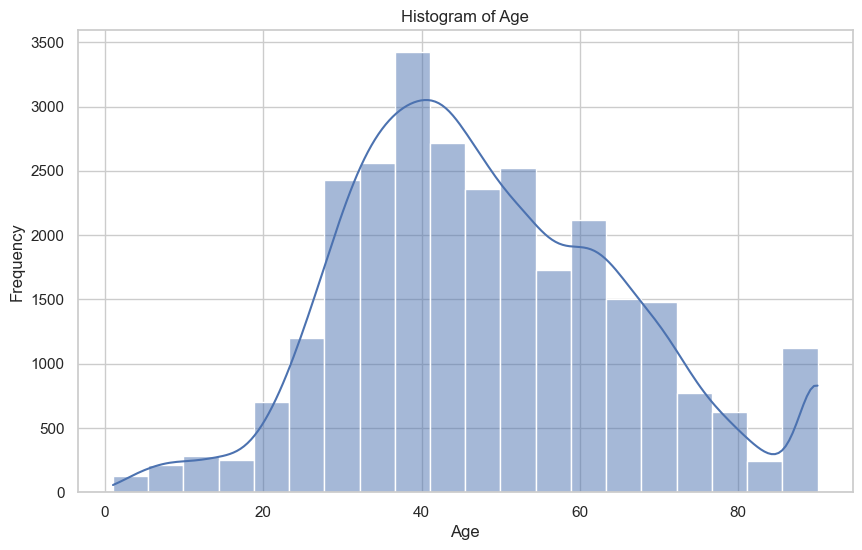

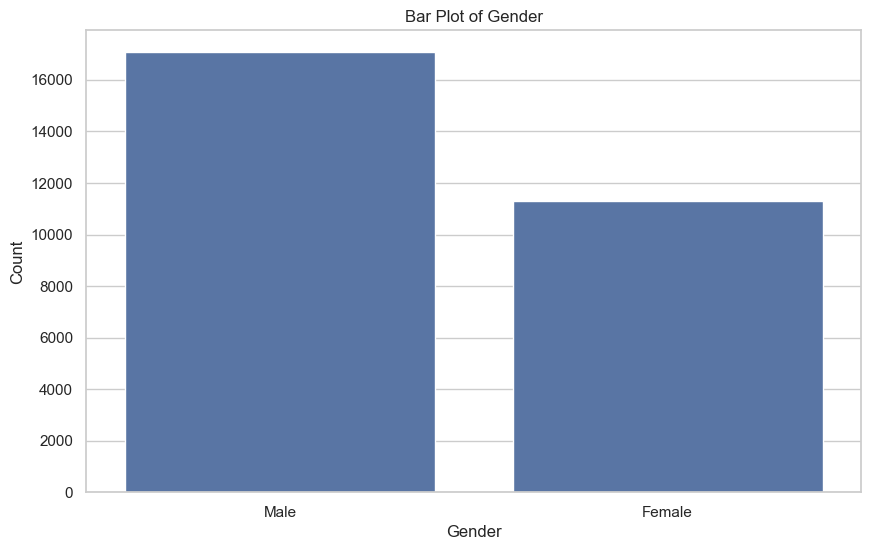

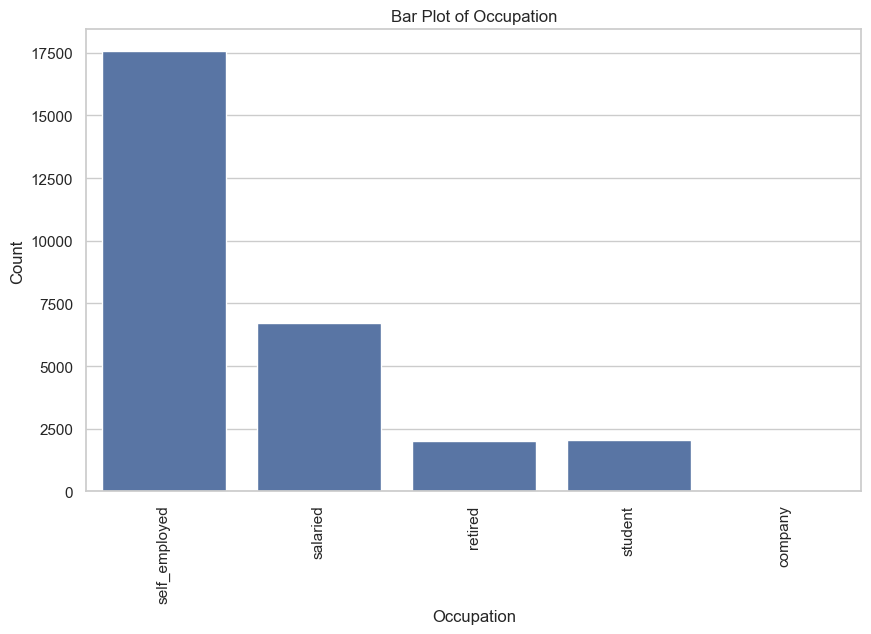

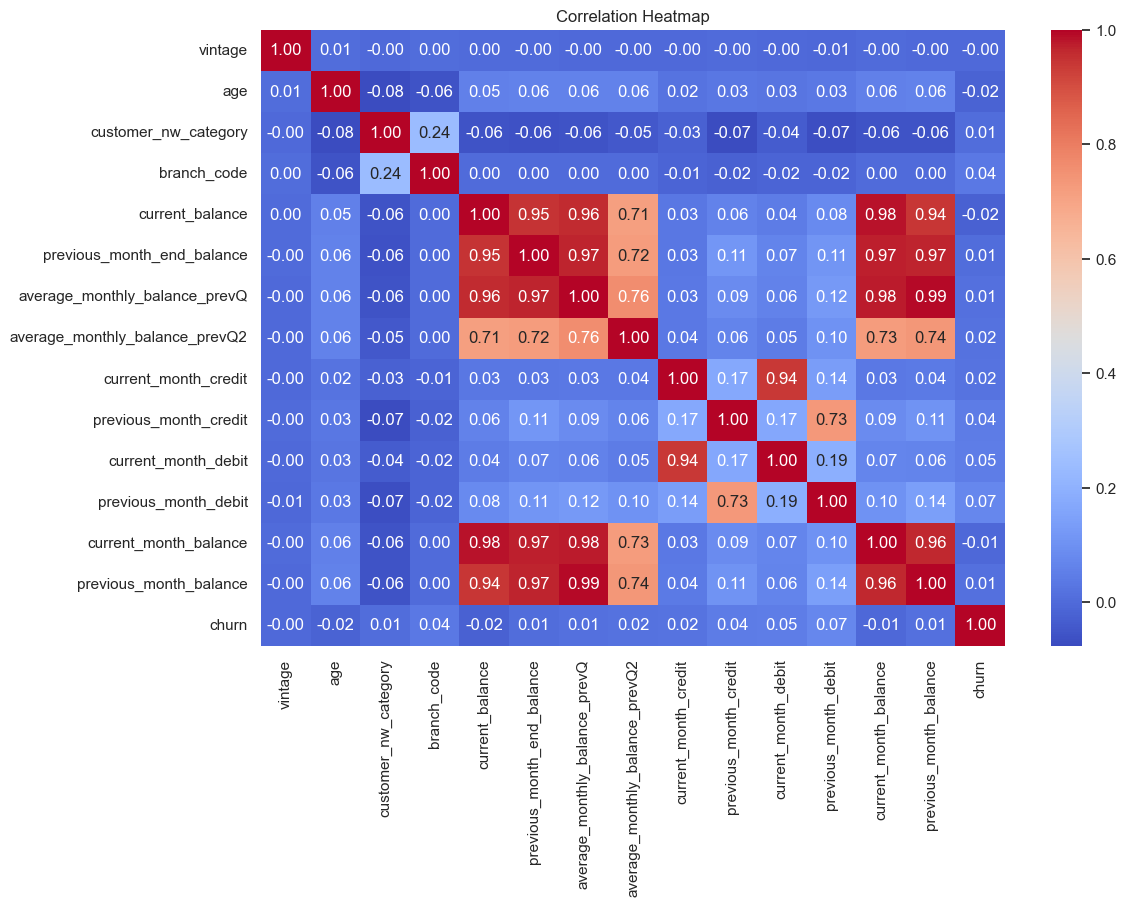

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Histogram of Age
plt.figure(figsize=(10, 6))
sns.histplot(raw['age'], bins=20, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bar plot of Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=raw, x='gender')
plt.title('Bar Plot of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Bar plot of Occupation
plt.figure(figsize=(10, 6))
sns.countplot(data=raw, x='occupation')
plt.title('Bar Plot of Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Remove non-numeric columns for correlation heatmap
numeric_df = raw.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


### Feature Engineering

In [6]:
from datetime import datetime as dt
# One-hot encode categorical variables
raw = pd.get_dummies(raw, columns=['gender', 'occupation'], drop_first=True)

#Days since last transaction
raw['last_transaction'] = pd.to_datetime(raw['last_transaction'], errors='coerce')

current_date = dt.today()  # or use a specific reference date if required
raw['days_since_last_trans'] = (current_date - raw['last_transaction']).dt.days

raw['days_since_last_trans'].fillna(raw['days_since_last_trans'].mode()[0], inplace=True)

# Average monthly balance over the past two quarters compared to current balance
raw['avg_balance_ratio_Q'] = raw['current_balance'] / raw['average_monthly_balance_prevQ']
raw['avg_balance_ratio_Q2'] = raw['current_balance'] / raw['average_monthly_balance_prevQ2']

C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_30136\657186796.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw['days_since_last_trans'].fillna(raw['days_since_last_trans'].mode()[0], inplace=True)


## Logistic Regression

### Prepare Data

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import statsmodels

# Define features and target
features = ['vintage', 'age', 'customer_nw_category', 'branch_code', 'current_balance', 'previous_month_end_balance',
            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2', 'current_month_credit', 
            'previous_month_credit', 'current_month_debit', 'previous_month_debit', 'current_month_balance', 
            'previous_month_balance', 'gender_Male', 'occupation_retired', 'occupation_salaried', 
            'occupation_self_employed', 'occupation_student', 'days_since_last_trans', 'avg_balance_ratio_Q', 
            'avg_balance_ratio_Q2']

X = raw[features]
y = raw['churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=958, stratify=y)

# Standardize features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train and Evaluate

In [8]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

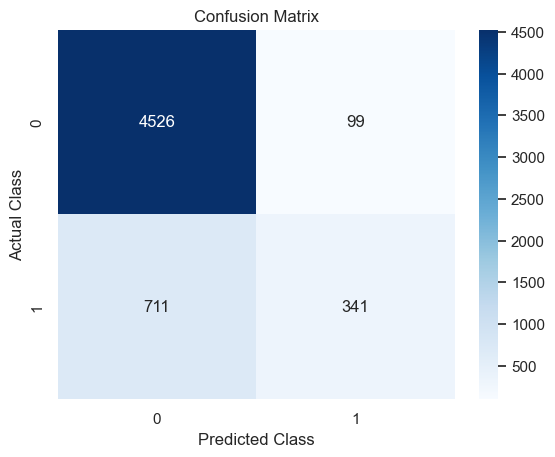


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4625
           1       0.78      0.32      0.46      1052

    accuracy                           0.86      5677
   macro avg       0.82      0.65      0.69      5677
weighted avg       0.85      0.86      0.83      5677



In [29]:
# Predictions
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

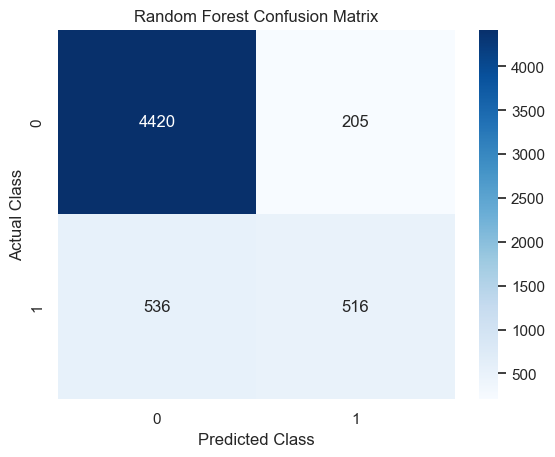


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4625
           1       0.72      0.49      0.58      1052

    accuracy                           0.87      5677
   macro avg       0.80      0.72      0.75      5677
weighted avg       0.86      0.87      0.86      5677



In [30]:
# Predictions
y_rf_pred = random_forest_model.predict(X_test)
y_rf_pred_proba = random_forest_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, y_rf_pred)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_rf_pred))

### Neural Network

In [12]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(random_state=42, hidden_layer_sizes=(128, 64), max_iter=300, solver='adam', activation='relu')
nn_model.fit(X_train, y_train)

C:\Users\f9tbqno\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)

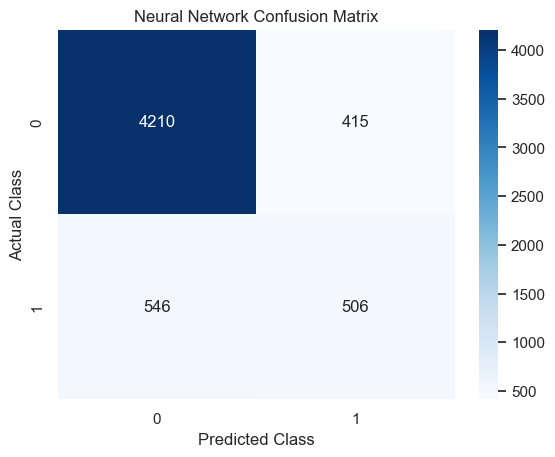


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4625
           1       0.55      0.48      0.51      1052

    accuracy                           0.83      5677
   macro avg       0.72      0.70      0.71      5677
weighted avg       0.82      0.83      0.83      5677



In [31]:
# Predictions
y_nn_pred = nn_model.predict(X_test)
y_nn_pred_proba = nn_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
nn_conf_matrix = confusion_matrix(y_test, y_nn_pred)
sns.heatmap(nn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_nn_pred))

### Evaluation

In [32]:
models = ["Logistic Regression", "Random Forest", "Neural Network"]
accuracy = []
precision = []
recall = []
f1_score = []
roc_auc = []

# Logistic Regression metrics
lr_accuracy = logistic_model.score(X_test, y_test)
lr_classification_report = classification_report(y_test, y_pred, output_dict=True)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba)

accuracy.append(lr_accuracy)
precision.append(lr_classification_report['1']['precision'])
recall.append(lr_classification_report['1']['recall'])
f1_score.append(lr_classification_report['1']['f1-score'])
roc_auc.append(lr_roc_auc)

# Random Forest metrics
rf_accuracy = random_forest_model.score(X_test, y_test)
rf_classification_report = classification_report(y_test, y_rf_pred, output_dict=True)
rf_roc_auc = roc_auc_score(y_test, y_rf_pred_proba)

accuracy.append(rf_accuracy)
precision.append(rf_classification_report['1']['precision'])
recall.append(rf_classification_report['1']['recall'])
f1_score.append(rf_classification_report['1']['f1-score'])
roc_auc.append(rf_roc_auc)

# Neural Network metrics
nn_accuracy = nn_model.score(X_test, y_test)
nn_classification_report = classification_report(y_test, y_nn_pred, output_dict=True)
nn_roc_auc = roc_auc_score(y_test, y_nn_pred_proba)

accuracy.append(nn_accuracy)
precision.append(nn_classification_report['1']['precision'])
recall.append(nn_classification_report['1']['recall'])
f1_score.append(nn_classification_report['1']['f1-score'])
roc_auc.append(nn_roc_auc)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
    "ROC-AUC": roc_auc
})

# Display the table
print("\nEvaluation Metrics for all three models:")
print(metrics_df)


Evaluation Metrics for all three models:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.857319   0.775000  0.324144  0.457105  0.797923
1        Random Forest  0.869473   0.715673  0.490494  0.582064  0.838356
2       Neural Network  0.830720   0.549403  0.480989  0.512924  0.774634


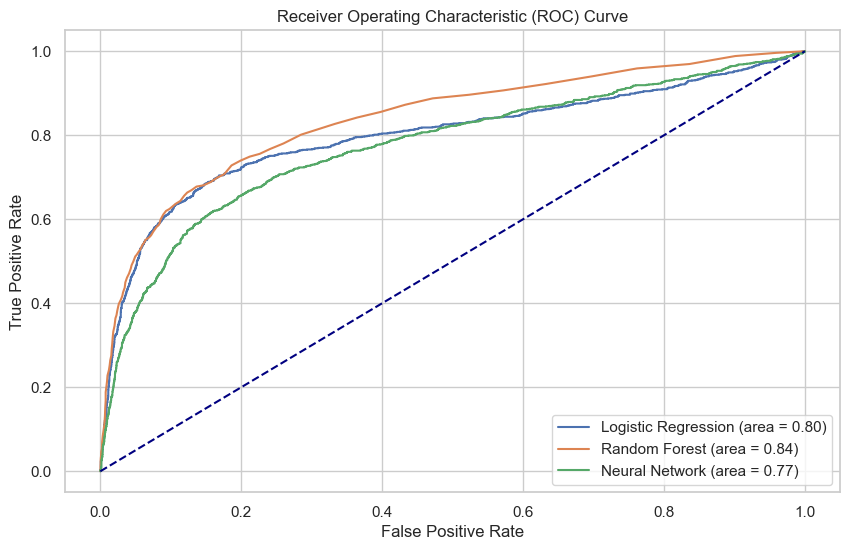

In [33]:
plt.figure(figsize=(10, 6))

# Logistic Regression ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % roc_auc_lr)

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_pred_proba)
roc_auc_rf = roc_auc_score(y_test, y_rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % roc_auc_rf)

# Neural Network ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_nn_pred_proba)
roc_auc_nn = roc_auc_score(y_test, y_nn_pred_proba)
plt.plot(fpr_nn, tpr_nn, label='Neural Network (area = %0.2f)' % roc_auc_nn)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### K-Means Clusterin

In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random

random.seed(958)
#Drop target & date column
features_for_clustering = raw.drop(columns=['churn', 'last_transaction'])

#Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# K-Means Clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster information to the original dataframe
raw['cluster'] = clusters


In [25]:
# Getting the cluster centers
cluster_centers = kmeans.cluster_centers_

# Scale back the cluster centers to the original scale
cluster_centers_original_scale = scaler.inverse_transform(cluster_centers)

# Create a DataFrame for better visualization
cluster_centers_df = pd.DataFrame(cluster_centers_original_scale, columns=features_for_clustering.columns)

# Calculate the variance of each feature across the cluster centers
variance_across_centers = cluster_centers_df.var()
print("\nFeature Variances Across Cluster Centers:")
print(variance_across_centers.sort_values(ascending=False))

from scipy.stats import f_oneway

# Perform ANOVA for each feature
anova_results = {}
for feature in features_for_clustering.columns:
    cluster_groups = [raw[raw['cluster'] == cluster][feature] for cluster in range(kmeans.n_clusters)]
    anova_results[feature] = f_oneway(*cluster_groups).pvalue

anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'ANOVA_P_Value'])
anova_results_df.sort_values(by='ANOVA_P_Value', inplace=True)
print("\nANOVA P-Values for Features:")
print(anova_results_df)


Feature Variances Across Cluster Centers:
current_balance                   6.958888e+12
current_month_balance             6.660408e+12
previous_month_end_balance        6.573346e+12
previous_month_balance            6.526845e+12
average_monthly_balance_prevQ     6.481664e+12
average_monthly_balance_prevQ2    5.005893e+12
current_month_debit               4.298152e+07
previous_month_debit              4.231974e+07
current_month_credit              1.798049e+07
previous_month_credit             9.924564e+06
branch_code                       5.538028e+05
vintage                           3.460987e+03
age                               7.316111e+02
days_since_last_trans             4.442575e+02
avg_balance_ratio_Q2              1.215564e+02
cluster                           2.492697e+00
occupation_self_employed          2.976860e-01
occupation_student                2.000000e-01
occupation_salaried               1.998914e-01
occupation_retired                1.964896e-01
gender_Male      

C:\Users\f9tbqno\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_30136\3664612875.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw, x='cluster', palette='viridis')


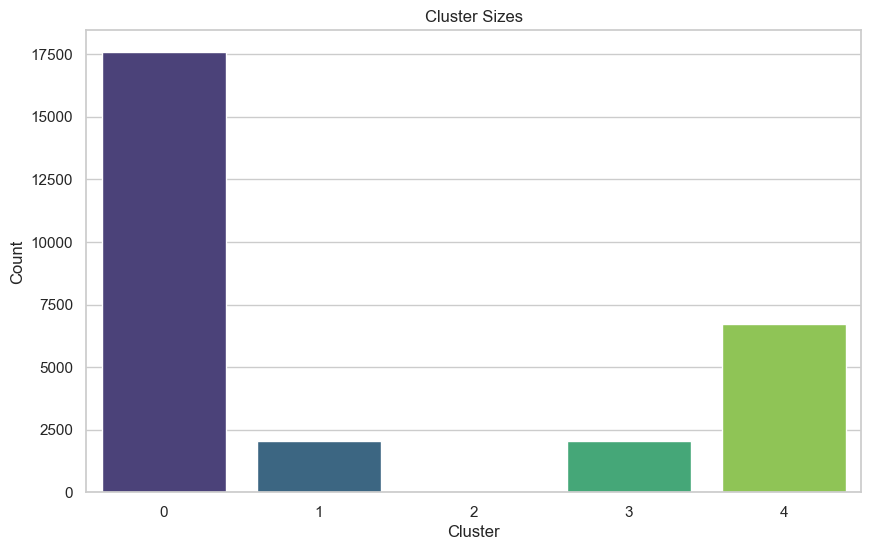

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=raw, x='cluster', palette='viridis')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()